In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import cv2
import random
import numpy as np
from sklearn import svm
import skimage.io as io
from skimage import color
from copy import deepcopy
from skimage import feature
from skimage import measure
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from numpy.linalg import norm
from skimage.filters import *
from skimage.color import rgb2gray
import time

from google.colab.patches import cv2_imshow

In [4]:
import sys
sys.path.append('/content/drive/My Drive/Comvis 20211/pipeline/')

from preprocessing import *
from staff_removal import *
from helper_methods import *

In [5]:
# img_name = '110002955-1_5_1.png'
img_path = '/content/drive/MyDrive/Comvis 20211/pipeline/test/110002955-1_5_1/110002955-1_5_1.png' 
threshold = 0.8
model_n = '/content/drive/MyDrive/Comvis 20211/pipeline/model/model.sav'
# filename = 'model/nn_trained_model_hog.sav'
model = pickle.load(open(model_n, 'rb'))
accidentals = ['x', 'hash', 'b', 'symbol_bb', 'd']

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


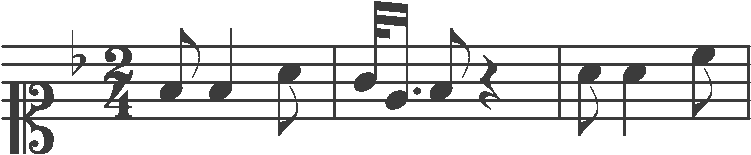

In [6]:
img = cv2.imread(img_path, False)
cv2_imshow(img)

# Image preprocessing

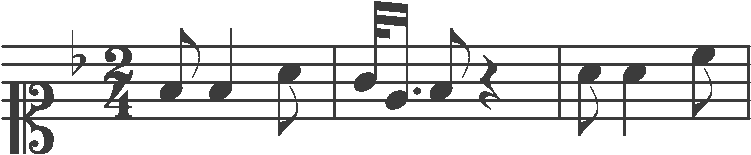

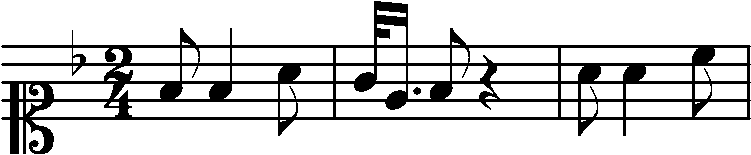

In [7]:
img = cv2.imread(img_path, False)
cv2_imshow(img)

height, width, in_img = preprocess_img(img_path)

cv2_imshow(in_img)

# Remove stafflines

In [8]:
staff_lines_thicknesses, staff_lines = get_staff_lines(width, height, in_img, threshold)

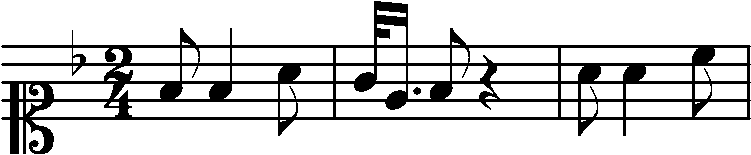

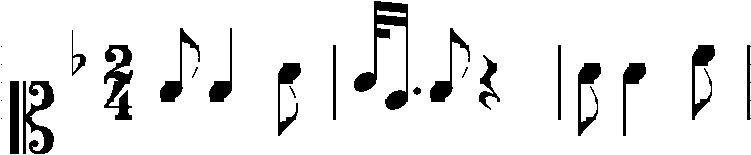

In [9]:
cv2_imshow(in_img)

cleaned = remove_staff_lines(in_img, width, staff_lines, staff_lines_thicknesses)
cut_positions, cutted = cut_image_into_buckets(cleaned, staff_lines)
ref_lines, lines_spacing = get_ref_lines(cut_positions, staff_lines)

cv2_imshow(cleaned)

# Symbol segmentation and prediction

In [10]:
def get_target_boundaries(label, cur_symbol, y2):
    if label == 'b_8':
        cutted_boundaries = cut_boundaries(cur_symbol, 2, y2)
        label = 'a_8'
    elif label == 'b_8_flipped':
        cutted_boundaries = cut_boundaries(cur_symbol, 2, y2)
        label = 'a_8_flipped'
    elif label == 'b_16':
        cutted_boundaries = cut_boundaries(cur_symbol, 4, y2)
        label = 'a_16'
    elif label == 'b_16_flipped':
        cutted_boundaries = cut_boundaries(cur_symbol, 4, y2)
        label = 'a_16_flipped'
    else: 
        cutted_boundaries = cut_boundaries(cur_symbol, 1, y2)

    return label, cutted_boundaries

def get_label_cutted_boundaries(boundary, height_before, cutted):
    # Get the current symbol #
    x1, y1, x2, y2 = boundary
    cur_symbol = cutted[y1-height_before:y2+1-height_before, x1:x2+1]

    cv2_imshow(cur_symbol)    

    # Clean and cut #
    cur_symbol = clean_and_cut(cur_symbol)
    cur_symbol = 255 - cur_symbol

    # Start prediction of the current symbol #
    feature = extract_hog_features(cur_symbol)
    label = str(model.predict([feature])[0])

    print(label, '\n')
    

    return get_target_boundaries(label, cur_symbol, y2)

In [12]:
def segmentation(height_before, in_img):
    n, m = in_img.shape

    blurred = cv2.GaussianBlur(in_img, (3, 3), 0)
    thresh = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY_INV)[1]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    dilate = cv2.dilate(thresh, kernel, iterations=1)

    # Find contours in the image
    cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]


    threshold_min_area = 0
    threshold_max_area = n * m

    symbols = []
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = cv2.contourArea(c)
        if area > threshold_min_area and area < threshold_max_area:
            symbols.append([x, y + height_before, x + w, y + h + height_before])

    return symbols

barline 



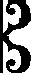

clef 



d 



a_4_flipped 

 e2/4


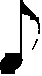

a_8 

 a1/8


symbol_bb 



a_4 

 a&&1/4


a_4_flipped 

 c2/4


clef 



barline 



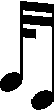

b_16 

 b2/16
 b2/16
 g1/16
 g1/16


dot 

.


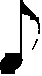

a_8 

 a1/8


symbol_bb 



clef 



barline 



a_4_flipped 

 c&&2/4


a_4_flipped 

 c2/4


a_4_flipped 

 e2/4


barline 



In [13]:
DROPS = ['.', 'meter', '{', '}']

last_acc = ''
last_num = ''
height_before = 0

to_write = []

for it in range(len(cutted)):
    is_started = False

    symbols_boundaries = segmentation(height_before, cutted[it])
    symbols_boundaries.sort(key = lambda x: (x[0], x[1]))
    
    for boundary in symbols_boundaries:
        label, cutted_boundaries = get_label_cutted_boundaries(boundary, height_before, cutted[it])

        if label == 'clef':
            is_started = True

        for cutted_boundary in cutted_boundaries:
            _, y1, _, y2 = cutted_boundary
            if is_started == True and label != 'barline' and label != 'clef':
                text = text_operation(label, ref_lines[it], lines_spacing[it], y1, y2)
                
                if (label == 't_2' or label == 't_4') and last_num == '':
                    last_num = text
                elif label in accidentals:
                    last_acc = text
                else:
                    if last_acc != '':
                        text = text[0] + last_acc + text[1:]
                        last_acc=  ''
                        
                    if last_num != '':
                        text = f'\meter<"{text}/{last_num}">'
                        last_num =  ''
                    
                    not_dot = label != 'dot'

                    symbol = not_dot * ' ' + text
                    print(symbol)
                    
                    to_dropped = False
                    for drop in DROPS:
                        if drop in symbol:
                            to_dropped = True

                    if not to_dropped:
                        to_write.append(symbol.strip())
        
    height_before += cutted[it].shape[0]

# Encode the final result

In [14]:
print(to_write)

['e2/4', 'a1/8', 'a&&1/4', 'c2/4', 'b2/16', 'b2/16', 'g1/16', 'g1/16', 'a1/8', 'c&&2/4', 'c2/4', 'e2/4']


In [15]:
def to_semantic(symbols): 
    acc_to_sem = {
        '#' : '#',
        '&' : 'b'
    }

    loc_to_sem = {
        '1' : '4',
        '2' : '5'
    }

    dur_to_sem = {
        '1' : 'whole',
        '2' : 'half',
        '4' : 'quarter',
        '8' : 'eighth',
        '16': 'sixteenth',
        '32': 'thirty_second'
    }

    sem_symbols = []
    for s in symbols:
            pitch = s[0]
            dur = s.split('/')[-1]
            remain = s.split('/')[0].replace(pitch, '')

            if len(remain) == 1:
                accidental = ''
                location = loc_to_sem[remain]
            else:
                accidental = acc_to_sem[remain[-2]]
                location = loc_to_sem[remain[-1]]

            sem_s = f'note-{pitch.upper()}{accidental}{location}_{dur_to_sem[dur]}'
            sem_symbols.append(sem_s)
    return sem_symbols

In [16]:
sem_write = to_semantic(to_write)
print(sem_write)

['note-E5_quarter', 'note-A4_eighth', 'note-Ab4_quarter', 'note-C5_quarter', 'note-B5_sixteenth', 'note-B5_sixteenth', 'note-G4_sixteenth', 'note-G4_sixteenth', 'note-A4_eighth', 'note-Cb5_quarter', 'note-C5_quarter', 'note-E5_quarter']
